In [1]:
import os; os.chdir("../")

In [2]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from inspect_tables import (targhe, timestamp_names, plate_names,
                            veicoli, fatture, draw_date_relplot,
                            read_data, overview, draw_report, draw_correlation)

pd.options.display.max_columns = 100

%matplotlib inline

Excel files can be downloaded
 - Veicoli: [[here](https://docs.google.com/spreadsheets/d/1KoSnpYXO4Roeg1nOscIsg4m6jvHN60k2/edit?usp=sharing&ouid=100767706223000279509&rtpof=true&sd=true)]
 - Fatture: [[here](https://teams.microsoft.com/l/file/2C9DF49B-8E52-438C-BEC5-F932517E22D0?tenantId=2a05ac92-2049-4a26-9b34-897763efc8e2&fileType=xlsx&objectUrl=https%3A%2F%2Fpolitoit.sharepoint.com%2Fteams%2FR-GRP_AI4Trucks%2FShared%20Documents%2FGeneral%2FAnalisi%2Feventi_manutenzioni_esterne%20(da%20fatture).xlsx&baseUrl=https%3A%2F%2Fpolitoit.sharepoint.com%2Fteams%2FR-GRP_AI4Trucks&serviceName=teams&threadId=19:uchivw6_oRyy6ipbNZlMKqkJWjGS5PxW2PGkqRwyvPE1@thread.tacv2&groupId=540e54c7-2583-4176-bcda-2ca674542369)]

# Data cleaning - [MOVIMATICA/vehicles](https://jupyter.polito.it/expert/hub/user-redirect/lab/tree/ai4Trucks/SEA%20Data%20Lake/MOVIMATICA)

In [3]:
df_MOV_vehicles = read_data("dataset2/Movimatica_vehicles.csv", cut_range=True)
# df_MOV_vehicles["position_date"] = df_MOV_vehicles.timestamp.dt.date
df_MOV_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,box,brand,chassis,engineHours,id,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,timestamp,date
0,0,NaN,0,NONE,D4257,Isuzu,TIS213369/18,922,7425,M21,Isuzu M21,40266,ZB478AN,45.829760,8.565098,1246284198,False,Viale Vittorio Veneto,IT,Italia,Lesa,Piemonte,28040.0,0,2021-09-15T08:08:35+00:00,motion_stop,Fine movimento,TIS213369/18,2021-09-15 08:08:35,2021-09-15
1,0,NaN,0,NONE,D4324,Isuzu,TIS283444/18,1060,7428,M21,Isuzu M21,44992,ZB476AN,45.960600,8.420151,1245229376,False,Via Pra' del Fico,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-09-14T14:25:37+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,2021-09-14 14:25:37,2021-09-14
2,0,NaN,0,NONE,D4314,Isuzu,TIS213368/18,881,7430,M21,Isuzu M21,28303,ZB477AN,41.784080,12.301694,1246658787,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,0,2021-09-15T09:58:28+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,2021-09-15 09:58:28,2021-09-15
3,0,NaN,0,NONE,D6190,Isuzu,TIS433613/18,1399,9606,P75,Isuzu P75,72298,ZB127AR,44.576473,7.900081,1246706229,False,Frazione Moriglione 25,IT,Italia,Novello,Piemonte,12060.0,0,2021-09-15T10:11:14+00:00,motion_stop,Fine movimento,TIS433613/18,2021-09-15 10:11:14,2021-09-15
4,0,NaN,0,NONE,D6220,Scania,TIMP44648/18,1841,9741,P320,Scania P320,21555,FV914SK,45.891518,10.890272,1246706761,True,Località Maza,IT,Italia,Arco,Trentino-Alto Adige,38062.0,0,2021-09-15T10:10:51+00:00,digital_input_change,Cambio Digital IN,TIMP44648/18,2021-09-15 10:10:51,2021-09-15


## Check ripetizioni

In [4]:
important = df_MOV_vehicles[df_MOV_vehicles.position_timestamp.dt.date<pd.Timestamp("2021-09-01")]
gpb = important.groupby(["plate", "position_timestamp"]).sav.count()
anom_plates = gpb[gpb>20].index.get_level_values(0).unique()
anom_date = gpb.reset_index().groupby("plate").position_timestamp.first()

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
check = []
for pl, g in important[important.plate.isin(anom_plates)].groupby(["plate"]):
    date_after = g[g.position_timestamp > anom_date[pl]].position_timestamp.min()
    check.append([
        pl,
        anom_date[pl],
        g[g.position_timestamp == anom_date[pl]].odometer.min(),
        date_after,
        g[g.position_timestamp == date_after].odometer.min()
    ])
    
Anomalies = pd.DataFrame(check, columns=["plate", "an_date", "km_an", "date_after", "km_after"])

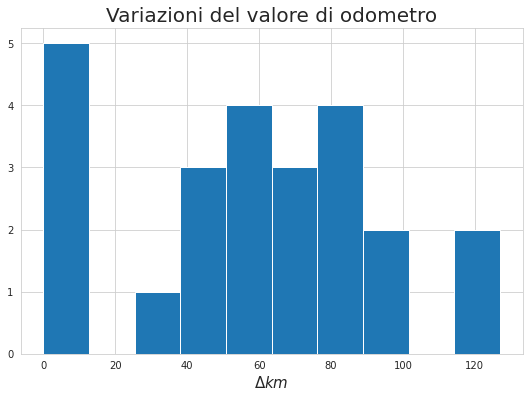

In [6]:
Anomalies["delta_date"] = Anomalies.date_after - Anomalies.an_date
Anomalies["delta_km"] = Anomalies.km_after - Anomalies.km_an
ax = Anomalies[["delta_date", "delta_km"]].delta_km.hist(figsize=(9,6))
ax.set_xlabel("$\Delta km$", size=15)
ax.set_title("Variazioni del valore di odometro", size=20)
plt.show()

In [ ]:
tm = df_MOV_vehicles.groupby(["plate", "position_timestamp"], as_index=False).count()#.index

In [9]:
from matplotlib import dates

No handles with labels found to put in legend.


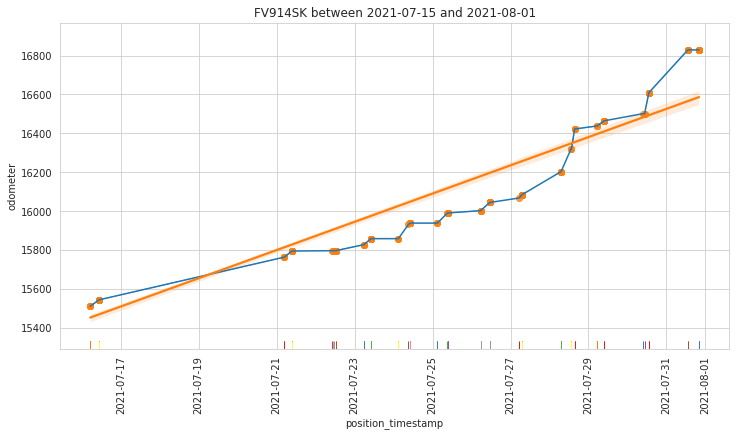

In [10]:
fig, g = plt.subplots(figsize=(12,6))

# @pyplot.FuncFormatter
# def fake_dates(x, pos):
#     """ Custom formater to turn floats into e.g., 2016-05-08"""
#     return dates.num2date(x).strftime('%Y-%m-%d')

sns.lineplot(data=tmp, x="position_timestamp", y="odometer", ax=g)
sns.regplot(data=tmp, x=dates.date2num(tmp.position_timestamp), y="odometer", ax=g)
# sns.lineplot(data=tmp, x="position_timestamp", y="engineHours", ax=g, color="violet")
g.set_title("FV914SK between 2021-07-15 and 2021-08-01")
sns.rugplot(data=tmp, x="position_timestamp", hue="filename", ax=g, legend=False, palette="Set1")
g.legend().remove()
g.tick_params(axis='x', rotation=90)

---
## Overview

In [10]:
df_MOV_vehicles, u_c = overview(df_MOV_vehicles)

    Dati raccolti tra 05/2021 e 01/2022 (con alcune eccezioni)

    40 parametri totali monitorati
    116608 record nel datalake
    30705 record non ripetuti
    35 truck di interesse monitorati
    In media 3331.657142857143 misurazioni per ogni mezzo su 5 mesi
    In media 13.168605307735742 misurazioni/giorno/mezzo (dettaglio successivamente)
    347 fatture associate.

Misurazioni con valore singolo:
alarm_tipology_label             NaN
customId                         NaN
fleet_id                           0
fleet_ilabel                     NaN
hasTelemetry                   False
lock_enabled                    True
lock_locked                    False
lock_status                 disabled
typology_id                COMPACTOR
typology_label          Compattatore
Name: 0, dtype: object
--> Colonne eliminate


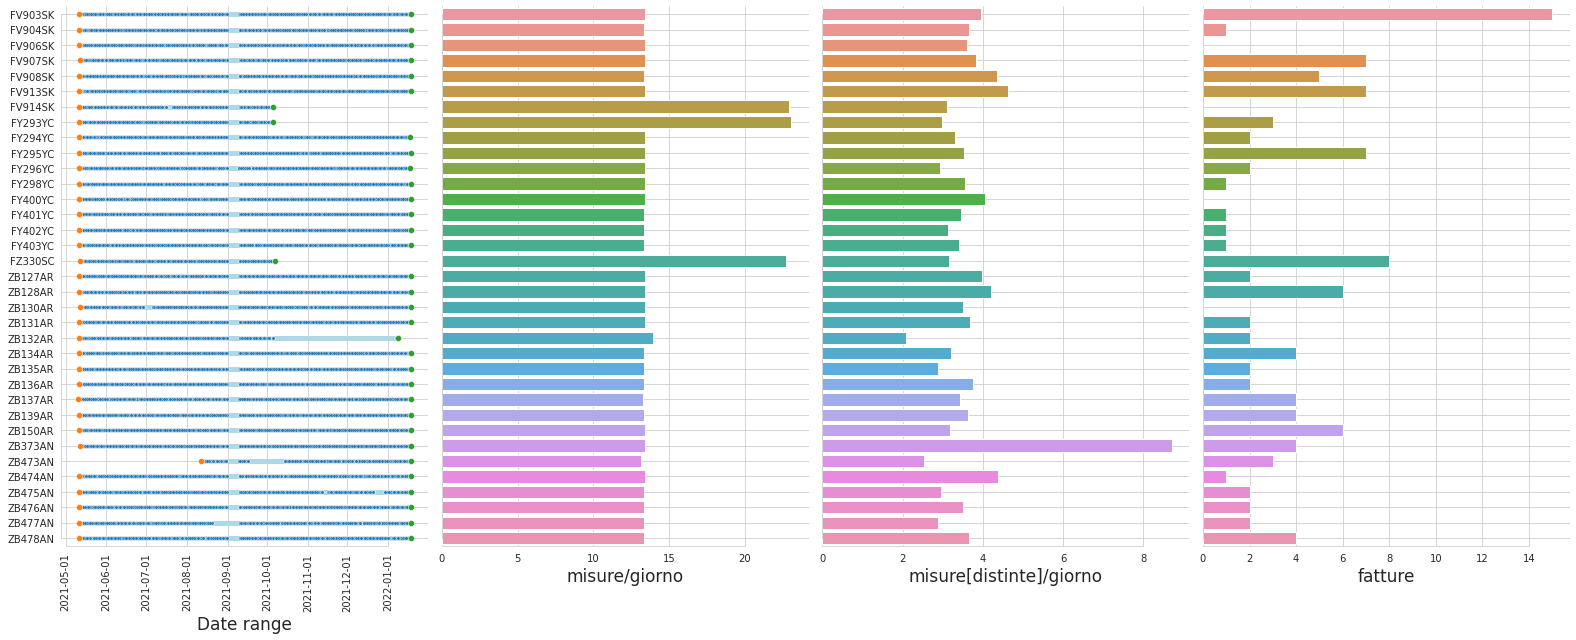

In [12]:
draw_report(df_MOV_vehicles)

In [14]:
df_MOV_vehicles = df_MOV_vehicles.drop_duplicates()

In [10]:
tmp = pd.read_csv("dataset2/Movimatica_vehicles.csv")

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
tmp.assign(date=pd.to_datetime(tmp.position_timestamp).dt.date).groupby(["date", "plate"]).id

---
## Monotonia

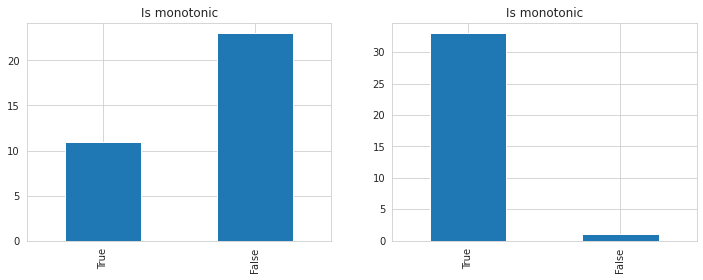

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_MOV_vehicles.groupby('plate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title="Is monotonic", ax=ax[0])
df_MOV_vehicles.groupby('plate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Is monotonic", ax=ax[1])
plt.show()

KeyboardInterrupt: 

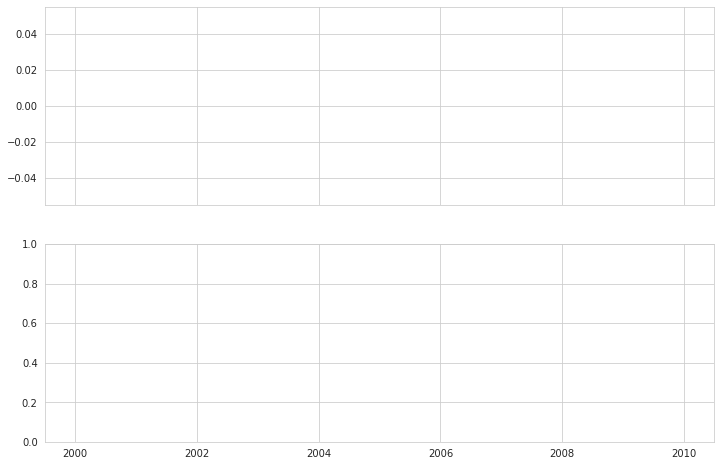

In [17]:
tmp = df_MOV_vehicles[df_MOV_vehicles.groupby('plate').odometer.transform(lambda x: not x.is_monotonic_increasing)]
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
sns.lineplot(data=tmp, x="timestamp", y="engineHours", hue="plate", ax=ax[0])
sns.rugplot(data=tmp, x="timestamp", hue="plate", ax=ax[0])

sns.lineplot(data=tmp, x="timestamp", y="odometer", hue="plate", ax=ax[1])
sns.rugplot(data=tmp, x="timestamp", hue="plate", ax=ax[1])

for i, (plate, d) in enumerate(tmp.groupby('plate')[["timestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="timestamp", y="odometer", markers="*", s=100)
    plt.text(x=d[d.df<0].timestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14,9), sharex=True)
tmp2 = df_MOV_vehicles[(df_MOV_vehicles.groupby('plate').engineHours.transform(lambda x: not x.is_monotonic_increasing))&(df_MOV_vehicles.timestamp.dt.year == 2021)]
sns.lineplot(data=tmp2, x="timestamp", y="engineHours", hue="plate", ax=ax[0])
sns.rugplot(data=tmp2, x="timestamp", hue="plate", ax=ax[0])

ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.15,0))

sns.lineplot(data=tmp2, x="timestamp", y="odometer", hue="plate", ax=ax[1])
sns.rugplot(data=tmp2, x="timestamp", hue="plate", ax=ax[1])

sns.despine(trim=True, left=True)
ax[1].get_legend().remove()
plt.show()

In [ ]:
df_MOV_vehicles[df_MOV_vehicles.timestamp.dt.date<pd.to_datetime("2021-09-01")].groupby('plate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_index(ascending=False)#.plot(kind="bar", title="Is monotonic (before 2021-09-01)")
# plt.show()

---
## Analisi Misurazioni giornaliere

In [15]:
view_fatture = fatture[(fatture.Targa.isin(df_MOV_vehicles.plate.unique()))&\
                       (fatture.Apertura_commessa.dt.date>=df_MOV_vehicles.timestamp.min().date())&\
                       (fatture.Apertura_commessa.dt.date<=df_MOV_vehicles.timestamp.max().date())]

In [7]:
tmp = pd.read_csv("dataset2/Movimatica_vehicles.csv")
tmp.assign(date=tmp.timestamp).groupby(["plate", ])

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label
0,0,NaN,0,NONE,NaN,D4257,Isuzu,TIS213369/18,NaN,922,0,NaN,False,7425,True,False,disabled,M21,Isuzu M21,40266,ZB478AN,45.829760,8.565098,1246284198,False,Viale Vittorio Veneto,IT,Italia,Lesa,Piemonte,28040.0,0,2021-09-15T08:08:35+00:00,motion_stop,Fine movimento,TIS213369/18,COMPACTOR,Compattatore
1,0,NaN,0,NONE,NaN,D4324,Isuzu,TIS283444/18,NaN,1060,0,NaN,False,7428,True,False,disabled,M21,Isuzu M21,44992,ZB476AN,45.960600,8.420151,1245229376,False,Via Pra' del Fico,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-09-14T14:25:37+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore
2,0,NaN,0,NONE,NaN,D4314,Isuzu,TIS213368/18,NaN,881,0,NaN,False,7430,True,False,disabled,M21,Isuzu M21,28303,ZB477AN,41.784080,12.301694,1246658787,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,0,2021-09-15T09:58:28+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore
3,0,NaN,0,NONE,NaN,D6190,Isuzu,TIS433613/18,NaN,1399,0,NaN,False,9606,True,False,disabled,P75,Isuzu P75,72298,ZB127AR,44.576473,7.900081,1246706229,False,Frazione Moriglione 25,IT,Italia,Novello,Piemonte,12060.0,0,2021-09-15T10:11:14+00:00,motion_stop,Fine movimento,TIS433613/18,COMPACTOR,Compattatore
4,0,NaN,0,NONE,NaN,D7349,Isuzu,TIS114471/20,NaN,162,0,NaN,True,11531,True,False,disabled,L35,Isuzu L35,1185,D7349,37.305702,13.587416,1246130991,True,Via Alessandro Manzoni 209,IT,Italia,Agrigento,Sicilia,92100.0,0,2021-09-15T07:10:56+00:00,digital_input_change,Cambio Digital IN,TIS114471/20,COMPACTOR,Compattatore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206672,1828897,Alert Alternatore,4,ANOMALY,NaN,D4345,Volvo,TIMP23759/20,NaN,416,0,NaN,False,9847,True,False,disabled,FL 280,Volvo FL 280,17279,EA203TN,43.875633,11.035627,1300686685,True,Autostrada Firenze-Mare,IT,Italia,Prato,Toscana,59100.0,73,2021-10-19T12:04:37+00:00,position,Posizione,TIMP23759/20,COMPACTOR,Compattatore
206673,0,NaN,0,NONE,NaN,D6250,Isuzu,TIS433614/18,NaN,2204,0,NaN,False,9720,True,False,disabled,P75,Isuzu P75,68206,ZB131AR,44.585186,7.903493,1300381456,True,Località Fasana,IT,Italia,Novello,Piemonte,12060.0,0,2021-10-19T09:40:57+00:00,digital_input_change,Cambio Digital IN,TIS433614/18,COMPACTOR,Compattatore
206674,0,NaN,0,NONE,NaN,D4256,Isuzu,TIS283439/18,NaN,505,0,NaN,False,7417,True,False,disabled,M21,Isuzu M21,21263,ZB473AN,41.958294,12.697287,1301265283,False,Via degli Abeti,IT,Italia,Guidonia Montecelio,Lazio,12.0,3,2021-10-19T15:24:24+00:00,digital_input_change,Cambio Digital IN,TIS283439/18,COMPACTOR,Compattatore
206675,0,NaN,0,NONE,NaN,D6226,Scania,TIMP44644/18,NaN,1918,0,NaN,False,9465,True,False,disabled,P280,Scania P280,69808,FV908SK,43.906975,11.020220,1300958400,False,Via Taliercio,IT,Italia,Montale,Toscana,51037.0,0,2021-10-19T13:35:57+00:00,motion_stop,Fine movimento,TIMP44644/18,COMPACTOR,Compattatore


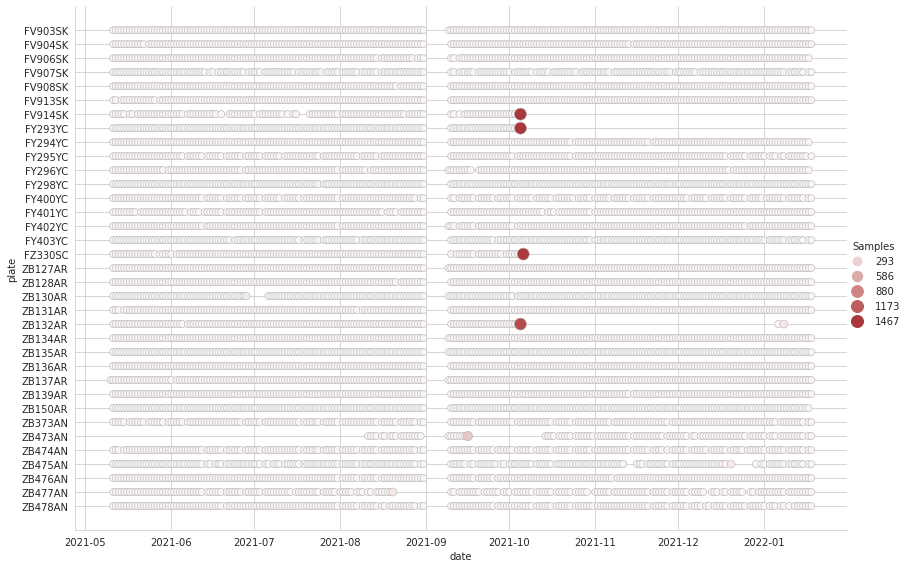

In [5]:
draw_date_relplot(df_MOV_vehicles)

In [25]:
df_MOV_vehicles.drop_duplicates().groupby(["plate", "date"]).agg({"timestamp": ["count","min", "max", lambda x: x.dt.hour.max()- x.dt.hour.min()], 
                                                                  "odometer": lambda x: np.max(x)- np.min(x),
                                                                  "engineHours": lambda x: np.max(x)- np.min(x)
                                                                 })

timestamp                                          \
                       count                 min                 max   
plate   date                                                           
FV903SK 2021-05-11         1 2021-05-11 11:16:09 2021-05-11 11:16:09   
        2021-05-12         2 2021-05-12 09:53:25 2021-05-12 09:53:25   
        2021-05-13         3 2021-05-13 03:36:26 2021-05-13 10:51:21   
        2021-05-14         2 2021-05-14 04:28:02 2021-05-14 09:35:38   
        2021-05-15         2 2021-05-15 04:40:43 2021-05-15 09:35:34   
...                      ...                 ...                 ...   
ZB478AN 2022-01-14         5 2022-01-14 06:07:07 2022-01-14 10:12:41   
        2022-01-15         5 2022-01-15 06:14:22 2022-01-15 09:26:59   
        2022-01-16         1 2022-01-16 09:27:12 2022-01-16 09:27:12   
        2022-01-17         6 2022-01-17 06:06:14 2022-01-17 10:54:33   
        2022-01-18         5 2022-01-18 06:04:00 2022-01-18 10:13:45   

                              odometer engineHours  
                   <lambda_0> <lambda>    <lambda>  
plate   date                                        
FV903SK 2021-05-11          0        0           0  
        2021-05-12          0        0           0  
        2021-05-13          7       86           8  
        2021-05-14          5       75           5  
        2021-05-15          5       64           5  
...                       ...      ...         ...  
ZB478AN 2022-01-14          4       41           1  
        2022-01-15          3       54           1  
        2022-01-16          0        0           0  
        2022-01-17          4       36           1  
        2022-01-18          4       33           1  

[7699 rows x 6 columns]

In [20]:
df_MOV_vehicles[(df_MOV_vehicles.plate=="FV903SK")&(df_MOV_vehicles.date=="2021-05-12")]

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,box,brand,chassis,engineHours,id,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,timestamp,date
34094,0,NaN,0,NONE,D6182,Scania,TIMP44643/18,1992,9568,P280,Scania P280,62348,FV903SK,44.58525,7.903901,1062697144,False,Località Fasana,IT,Italia,Fasana,Piemonte,12060.0,1,2021-05-12T09:53:25+00:00,digital_input_change,Cambio Digital IN,TIMP44643/18,2021-05-12 09:53:25,2021-05-12
106153,0,NaN,0,NONE,D6182,Scania,TIMP44643/18,1992,9568,P280,Scania P280,62348,FV903SK,44.58525,7.903901,1062697144,False,Località Fasana,IT,Italia,Fasana,Piemonte,12060.0,1,2021-05-12T11:53:25+02:00,digital_input_change,Cambio Digital IN,TIMP44643/18,2021-05-12 09:53:25,2021-05-12


In [21]:
df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"].position_typology_id.value_counts().to_frame()

,position_typology_id
digital_input_change,847
motion_stop,193
position,3
external_power_on,1


KeyboardInterrupt: 

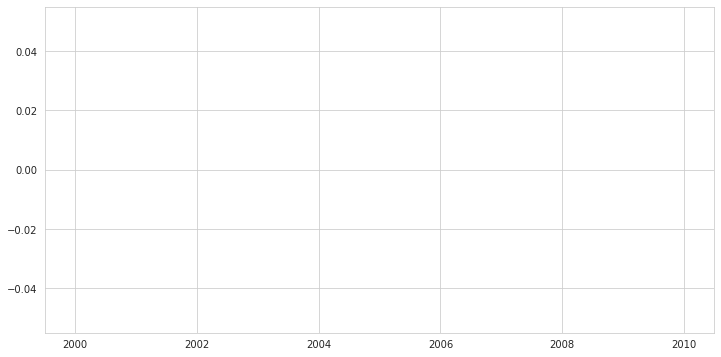

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
             x="timestamp",
             y="odometer",
             ax=ax
            )

sns.scatterplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
                x="timestamp",
                y="odometer",
                hue="position_typology_id",
                style="position_typology_id",
                ax=ax,
                zorder=4,
                s=20
               )
sns.rugplot(data=df_MOV_vehicles[df_MOV_vehicles.plate=="ZB373AN"],
            x="timestamp",
            hue="position_typology_id"
           )
ax.set_title("Odometer for ZB373AN")
plt.show()

In [ ]:
# TO FIX!
tmp = df_MOV_vehicles.groupby(['plate', "position_date"]).engineHours.count().reset_index()
g = sns.FacetGrid(tmp, row="plate", aspect=2)
g.map(sns.barplot, "position_date", "engineHours")

---
## Correlation

In [20]:
df_MOV_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label,filename,position_date
0,0,NaN,0,NONE,NaN,D4257,Isuzu,TIS213369/18,NaN,4514,0,NaN,False,7425,True,False,disabled,M21,Isuzu M21,30349,ZB478AN,45.960472,8.421074,1060885110,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,12,2021-05-11 07:34:28+00:00,digital_input_change,Cambio Digital IN,TIS213369/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
1,0,NaN,0,NONE,NaN,D4324,Isuzu,TIS283444/18,NaN,4426,0,NaN,False,7428,True,False,disabled,M21,Isuzu M21,37532,ZB476AN,45.960022,8.420602,1061115070,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877.0,0,2021-05-11 09:26:41+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
2,0,NaN,0,NONE,NaN,D4314,Isuzu,TIS213368/18,NaN,3497,0,NaN,False,7430,True,False,disabled,M21,Isuzu M21,24933,ZB477AN,41.784200,12.301565,1061114233,False,Via del Macchione Rotondo,IT,Italia,Roma,Lazio,119.0,1,2021-05-11 09:20:15+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
3,0,NaN,0,NONE,NaN,D6190,Isuzu,TIS433613/18,NaN,1395,0,NaN,False,9606,True,False,disabled,P75,Isuzu P75,63197,ZB127AR,44.585390,7.902978,1061318067,False,Località Piano 5,IT,Italia,Novello,Piemonte,12060.0,0,2021-05-11 10:40:38+00:00,external_power_on,Alimentazione ripristinata,TIS433613/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11
6,0,NaN,0,NONE,NaN,D6220,Scania,TIMP44648/18,NaN,959,0,NaN,False,9741,True,False,disabled,P320,Scania P320,11308,FV914SK,45.947212,10.905164,1061560745,False,Località Matoni 1,IT,Italia,Dro,Trentino-Alto Adige,38074.0,1,2021-05-11 13:08:58+00:00,external_power_on,Alimentazione ripristinata,TIMP44648/18,COMPACTOR,Compattatore,2021-05-11-17,2021-05-11


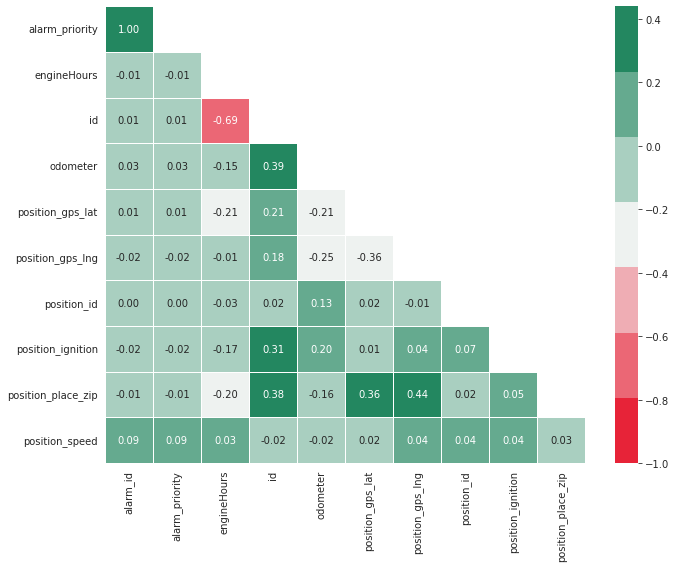

In [25]:
pseudo_plate = [c for c in df_MOV_vehicles.columns if len(df_MOV_vehicles[c].unique()) == 35]
g = draw_correlation(df_MOV_vehicles.drop(pseudo_plate, axis=1))

---
## PCA

In [179]:
data_std.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')]).index

Index(['odometer', 'engineHours', 'position_speed', 'position_ignition'], dtype='object')

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# numerical_cols = df_MOV_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# numerical_cols = df_MOV_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# data_std = df_MOV_vehicles[numerical_cols[numerical_cols].index].drop(["id", "alarm_id"], axis=1)
data_std = df_MOV_vehicles[["odometer", "engineHours", "position_speed", "position_ignition"]].copy()

data_std[data_std.columns] = StandardScaler().fit_transform(data_std[data_std.columns])
data_std.head()

,odometer,engineHours,position_speed,position_ignition
119,-1.306122,-0.714378,-0.293483,-0.827088
35316,-1.306122,-0.714378,-0.293483,-0.827088
63045,0.927527,-0.852566,-0.293483,-0.827088
35269,1.773145,-0.711330,-0.293483,1.209062
35272,-0.963058,-0.809890,-0.151331,-0.827088


In [182]:
data_std = data_std.dropna()
pca = PCA(n_components=4)
pca.fit(data_std)
projection = pca.transform(data_std)

In [183]:
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.33576503, 0.25413525, 0.21557315, 0.19452656])

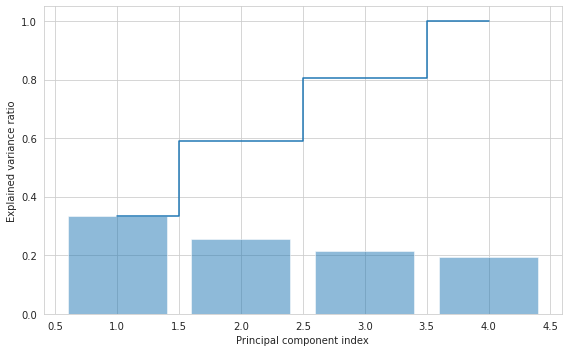

In [184]:
cum_sum_eigenvalues = np.cumsum(var_ratio)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_ratio) + 1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("PCA_6")
plt.show()

In [165]:
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(len(var_ratio))]

In [167]:
initial_feature_names = data_std.columns
most_important_names = {i: initial_feature_names[most_important[i]].to_list() for i in range(len(var_ratio))}

In [168]:
most_important_names

{0: ['odometer', 'position_place_zip', 'position_gps_lng'],
 1: ['position_gps_lng', 'engineHours', 'position_gps_lat'],
 2: ['position_gps_lng', 'position_ignition', 'position_gps_lat'],
 3: ['position_id', 'alarm_priority', 'position_speed'],
 4: ['engineHours', 'alarm_priority', 'position_id'],
 5: ['position_ignition', 'alarm_priority', 'position_speed']}

**position_place_zip??**

In [ ]:

veicoli["Sistema Gps Tracking"] = veicoli["Sistema Gps Tracking"].str.replace(' ', '').str.split('+')#.unique()
veicoli = veicoli.explode("Sistema Gps Tracking").groupby(['Targa', 'Sistema Gps Tracking']).first()

fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx")
fatture.Apertura_commessa = pd.to_datetime(fatture.Apertura_commessa)

---
## MOVIMATICA/vehiclesTrip

In [107]:
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1', '1.0'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0', '0.0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [108]:
df = read_data("dataset/MOVIMATICA_vehiclesTrip.csv")

df.start_ignition = df.start_ignition.apply(str2bool)
df.stop_ignition = df.stop_ignition.apply(str2bool)

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8,22,34,35,36,37,38,39,40,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [109]:
df, _ = overview(df)

    Dati raccolti tra 05/2021 e 09/2021 (con alcune eccezioni)

    44 parametri totali monitorati
    491710 record nel datalake
    12876 record non ripetuti
    35 truck di interesse monitorati
    In media 14048.857142857143 misurazioni per ogni mezzo su 5 mesi
    In media 104.06560846560846 misurazioni/giorno/mezzo (dettaglio successivamente)
    285 fatture associate.

Misurazioni con valore singolo:
start_place_country_id           IT
start_place_country_label    Italia
stop_place_country_id            IT
stop_place_country_label     Italia
0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
5                               NaN
6                               NaN
7                               NaN
8                               NaN
9                               NaN
Name: 120, dtype: object
--> Colonne eliminate


In [110]:
for c in ["start_timestamp", "stop_timestamp"]:
    df[c] = pd.to_datetime(df[c])

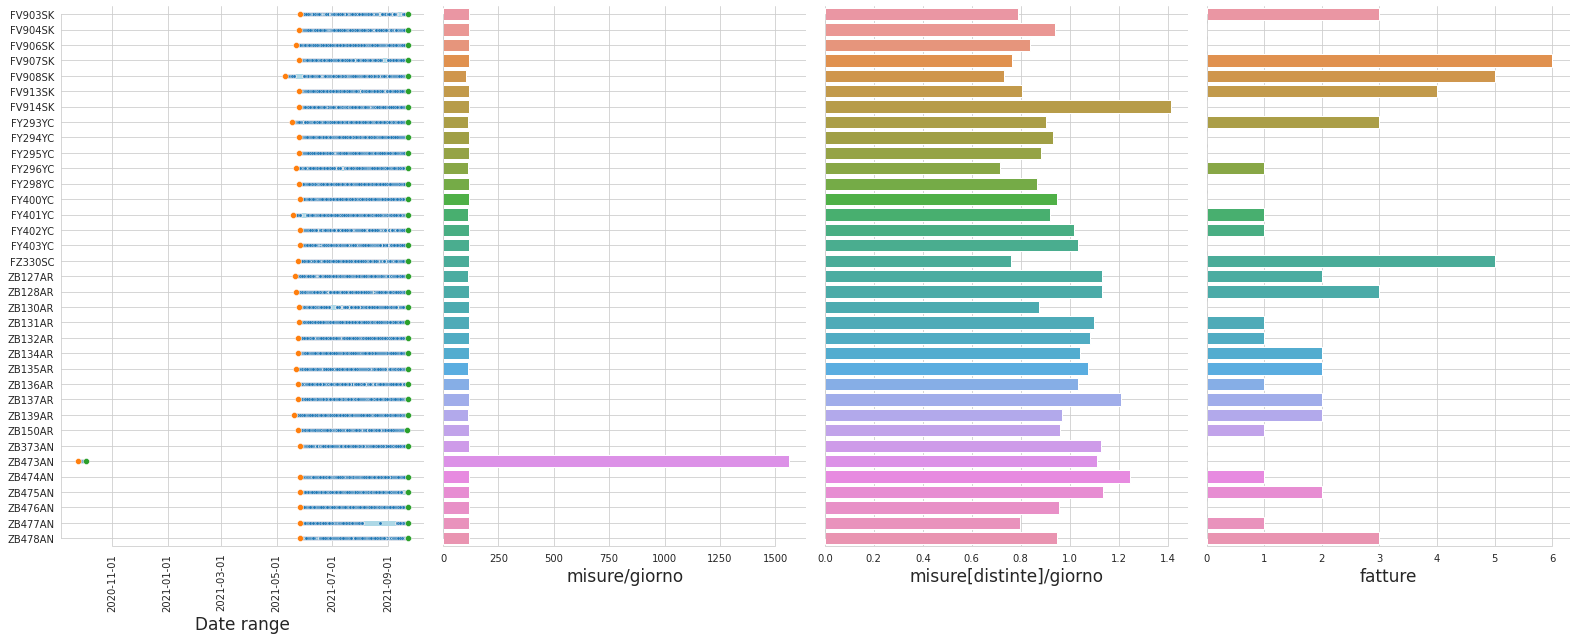

In [111]:
draw_report(df)

In [112]:
df = df[df.timestamp.dt.year==2021].drop_duplicates()
df.shape

(12866, 30)

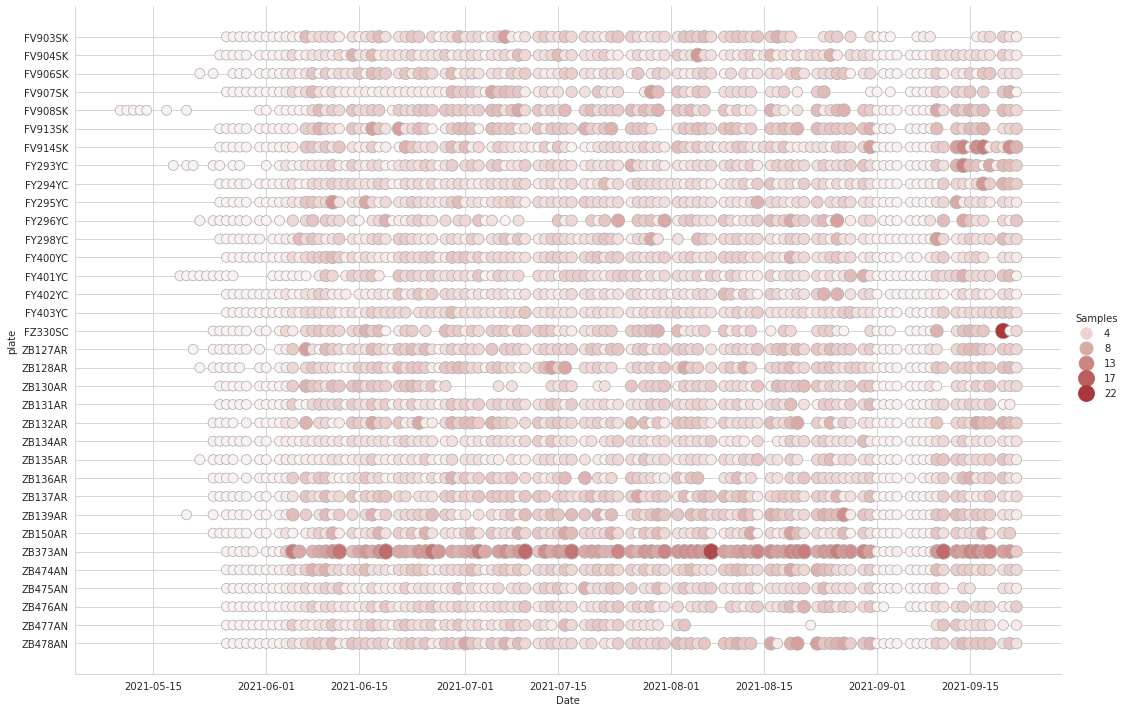

In [113]:
rl = draw_date_relplot(df, plate="plate")

In [127]:
print(df.columns)

Index(['plate', 'id', 'vehicle', 'start_id', 'start_timestamp',
       'start_typology_id', 'start_typology_label', 'start_ignition',
       'start_speed', 'start_place_state', 'start_place_place',
       'start_place_address', 'start_place_zip', 'start_gps_lat',
       'start_gps_lng', 'stop_id', 'stop_timestamp', 'stop_typology_id',
       'stop_typology_label', 'stop_ignition', 'stop_speed',
       'stop_place_state', 'stop_place_place', 'stop_place_address',
       'stop_place_zip', 'stop_gps_lat', 'stop_gps_lng', 'duration',
       'distance', 'timestamp', 'Date'],
      dtype='object')


In [125]:
for c in df.columns:
    if "start" in c:
        print(f"{c.split('start_')[-1]}")

id
timestamp
typology_id
typology_label
ignition
speed
place_state
place_place
place_address
place_zip
gps_lat
gps_lng


In [114]:
df.head()

,plate,id,vehicle,start_id,start_timestamp,start_typology_id,start_typology_label,start_ignition,start_speed,start_place_state,start_place_place,start_place_address,start_place_zip,start_gps_lat,start_gps_lng,stop_id,stop_timestamp,stop_typology_id,stop_typology_label,stop_ignition,stop_speed,stop_place_state,stop_place_place,stop_place_address,stop_place_zip,stop_gps_lat,stop_gps_lng,duration,distance,timestamp,Date
120,FV903SK,6df3868a,9568.0,1.094092e+09,2021-06-04 03:05:54+00:00,digital_input_change,Cambio Digital IN,True,0.0,Piemonte,Fasana,Località Fasana,12060.0,44.585056,7.902806,1.094993e+09,2021-06-04 10:43:01+00:00,digital_input_change,Cambio Digital IN,False,0.0,Piemonte,Novello,Località Fasana,12060.0,44.585164,7.903407,457.0,67.267,2021-06-04 03:05:54,2021-06-04
121,FV903SK,6a35ecac,9568.0,1.092230e+09,2021-06-03 03:50:53+00:00,digital_input_change,Cambio Digital IN,True,0.0,Piemonte,Novello,Località Piano 5,12060.0,44.585400,7.902978,1.092975e+09,2021-06-03 09:56:54+00:00,motion_stop,Fine movimento,False,0.0,Piemonte,Fasana,Località Fasana,12060.0,44.585056,7.902806,366.0,98.737,2021-06-03 03:50:53,2021-06-03
122,FV903SK,ffa5183a,9568.0,1.091459e+09,2021-06-02 03:08:39+00:00,digital_input_change,Cambio Digital IN,True,0.0,Piemonte,Novello,Località Fasana,12060.0,44.585217,7.903450,1.091828e+09,2021-06-02 10:10:12+00:00,digital_input_change,Cambio Digital IN,False,0.0,Piemonte,Novello,Località Piano 5,12060.0,44.585400,7.902978,421.0,41.213,2021-06-02 03:08:39,2021-06-02
123,FV903SK,85c5d008,9568.0,1.089606e+09,2021-06-01 02:37:10+00:00,digital_input_change,Cambio Digital IN,True,0.0,Piemonte,Novello,Località Piano 5,12060.0,44.585346,7.902978,1.090240e+09,2021-06-01 09:28:54+00:00,digital_input_change,Cambio Digital IN,False,0.0,Piemonte,Novello,Località Fasana,12060.0,44.585217,7.903450,411.0,65.838,2021-06-01 02:37:10,2021-06-01
124,FV903SK,08fa4652,9568.0,1.087804e+09,2021-05-31 03:41:37+00:00,digital_input_change,Cambio Digital IN,True,0.0,Piemonte,Novello,Località Piano 1,12060.0,44.584584,7.902463,1.088772e+09,2021-05-31 11:48:06+00:00,digital_input_change,Cambio Digital IN,False,0.0,Piemonte,Novello,Località Piano 5,12060.0,44.585346,7.902978,486.0,79.885,2021-05-31 03:41:37,2021-05-31


In [128]:
delta_timestamps = df.sort_values(by=["plate", "timestamp"]).groupby(["plate"]).apply(lambda gpb: gpb.start_timestamp.shift(-1) - gpb.stop_timestamp)
(delta_timestamps.dt.seconds>0).value_counts()#.plot(kind="bar")

True     12764
False      102
dtype: int64

Intervals are mostly **disjoint**

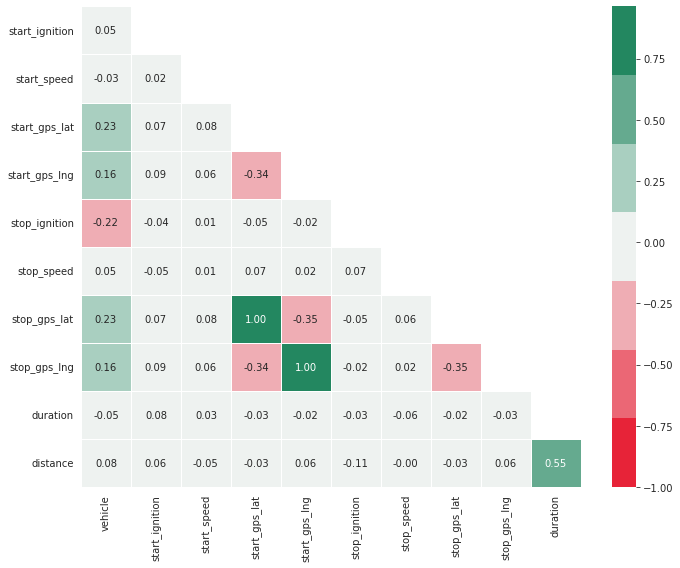

In [118]:
ignore_list = [c for c in df.columns if any([hw in c for hw in ["id", "zip"]])]
g = draw_correlation(df.drop(ignore_list, axis=1))

<AxesSubplot:>

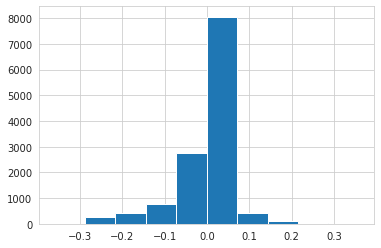

In [121]:
(df.start_gps_lng - df.stop_gps_lng).hist()